# Simulation stratification: Housing data set (14. November)

“Target” is the feature we are going to predict. It represnts the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold

# show working directory
os.getcwd()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import helper funcitons
from utils import fold_visualizer


## Generat Data Set Housing data set

Inspiration from : https://medium.com/@polanitzer/machine-learning-for-california-housing-e979ec5f5971

In [2]:
from sklearn.datasets import fetch_california_housing
housing_data = fetch_california_housing()
descr = housing_data['DESCR']
feature_names = housing_data['feature_names']
data = housing_data['data']
target = housing_data['target']
df1 = pd.DataFrame(data=data)
df1.rename(columns={0: feature_names[0], 1: feature_names[1], 2: feature_names[2], 3: feature_names[3],
 4: feature_names[4], 5: feature_names[5], 6: feature_names[6], 7: feature_names[7]}, inplace=True)
df2 = pd.DataFrame(data=target)
df2.rename(columns={0: 'Target'}, inplace=True)
housing = pd.concat([df1, df2], axis=1)
print(housing.columns)


print('dimension of housing data: {}'.format(housing.shape))
print(housing.info())
housing.head()

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Target'],
      dtype='object')
dimension of housing data: (20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


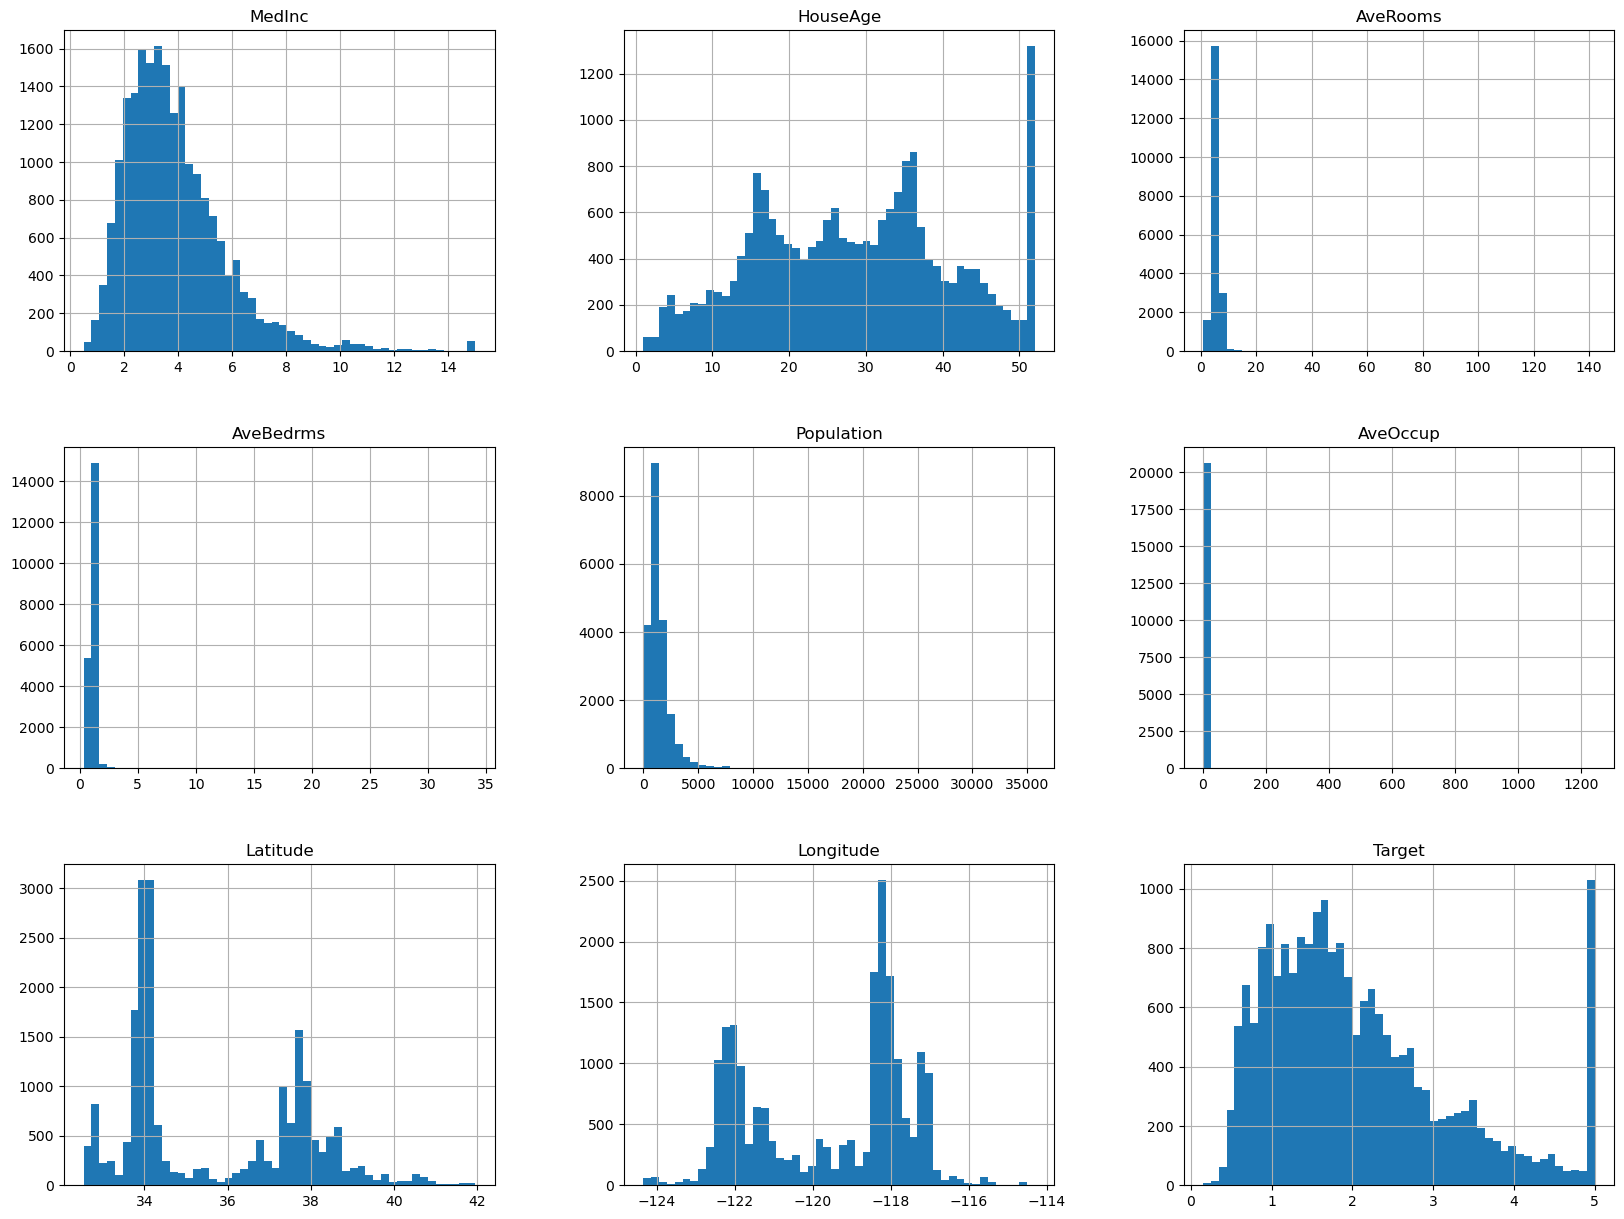

In [3]:
# plot variable as histogram
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [4]:
# Test and trianing data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(housing.loc[:, housing.columns != 'Target'], housing['Target'], random_state=66)


In [19]:
housing_features = [x for i,x in enumerate(housing.columns) if i!=8]
tree =  RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42)
tree.fit(X_train, y_train)
t1 = tree.score(X_train, y_train)
t2 = tree.score(X_test, y_test)
print('R² of RandomForestRegressor on training set (random samploing): {:.3f}'.format(t1))
print('R² of RandomForestRegressor on test set(random samploing): {:.3f}'.format(t2))

R² of RandomForestRegressor on training set (random samploing): 0.762
R² of RandomForestRegressor on test set(random samploing): 0.733


Feature importances:
[0.67312576 0.04543142 0.02675692 0.00524909 0.01038621 0.14440521
 0.05027619 0.0443692 ]


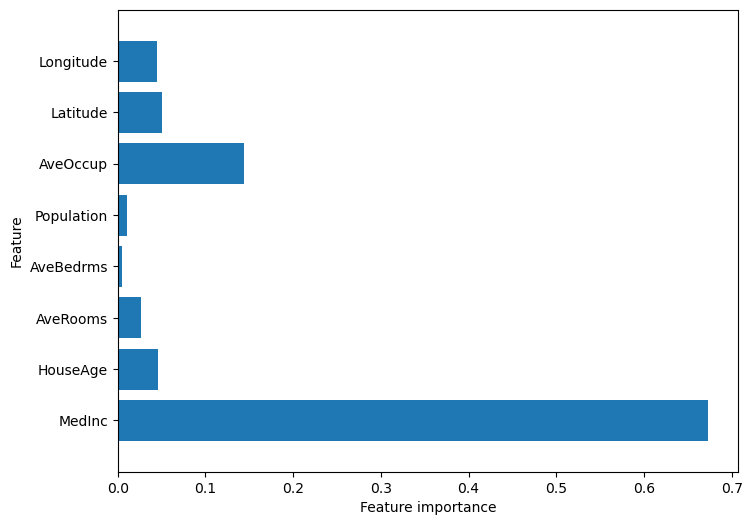

In [8]:
print('Feature importances:\n{}'.format(tree.feature_importances_))
def plot_feature_importances_housing(model):
 plt.figure(figsize=(8,6))
 n_features = 8
 plt.barh(range(n_features), model.feature_importances_, align='center')
 plt.yticks(np.arange(n_features), housing_features)
 plt.xlabel('Feature importance')
 plt.ylabel('Feature')
 plt.ylim(-1, n_features)
plot_feature_importances_housing(tree)
plt.savefig('feature_importance')

## Using general random cross-validation

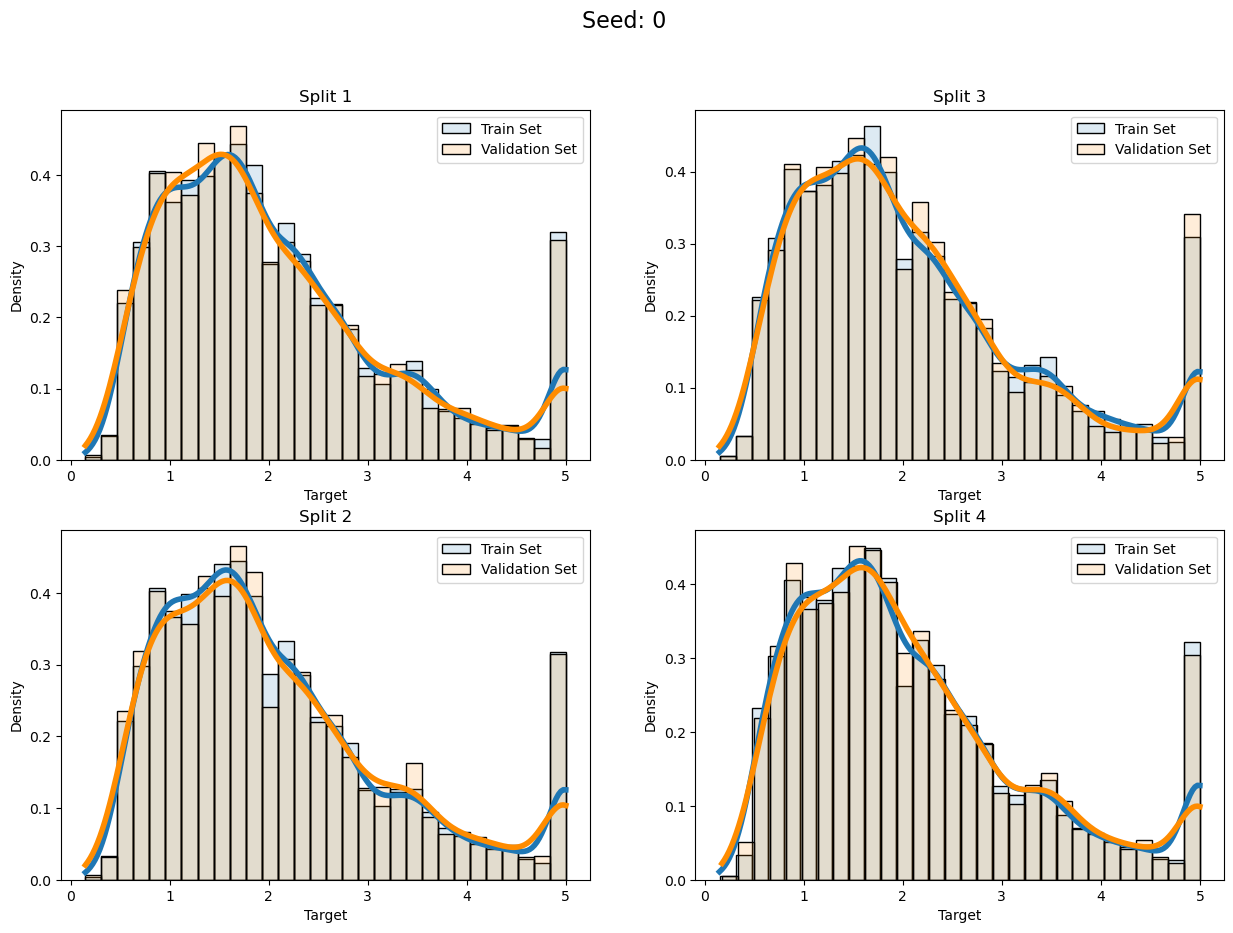

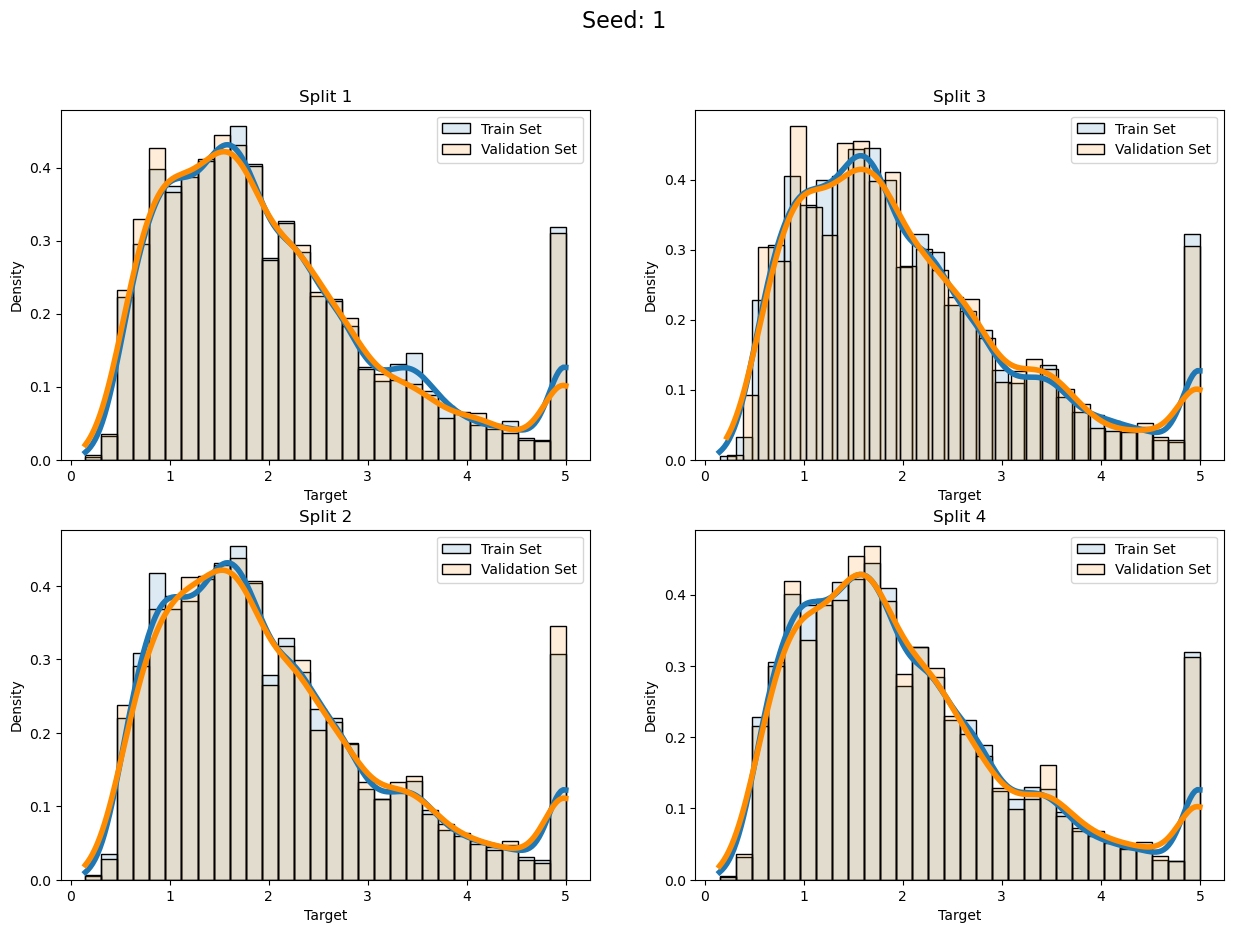

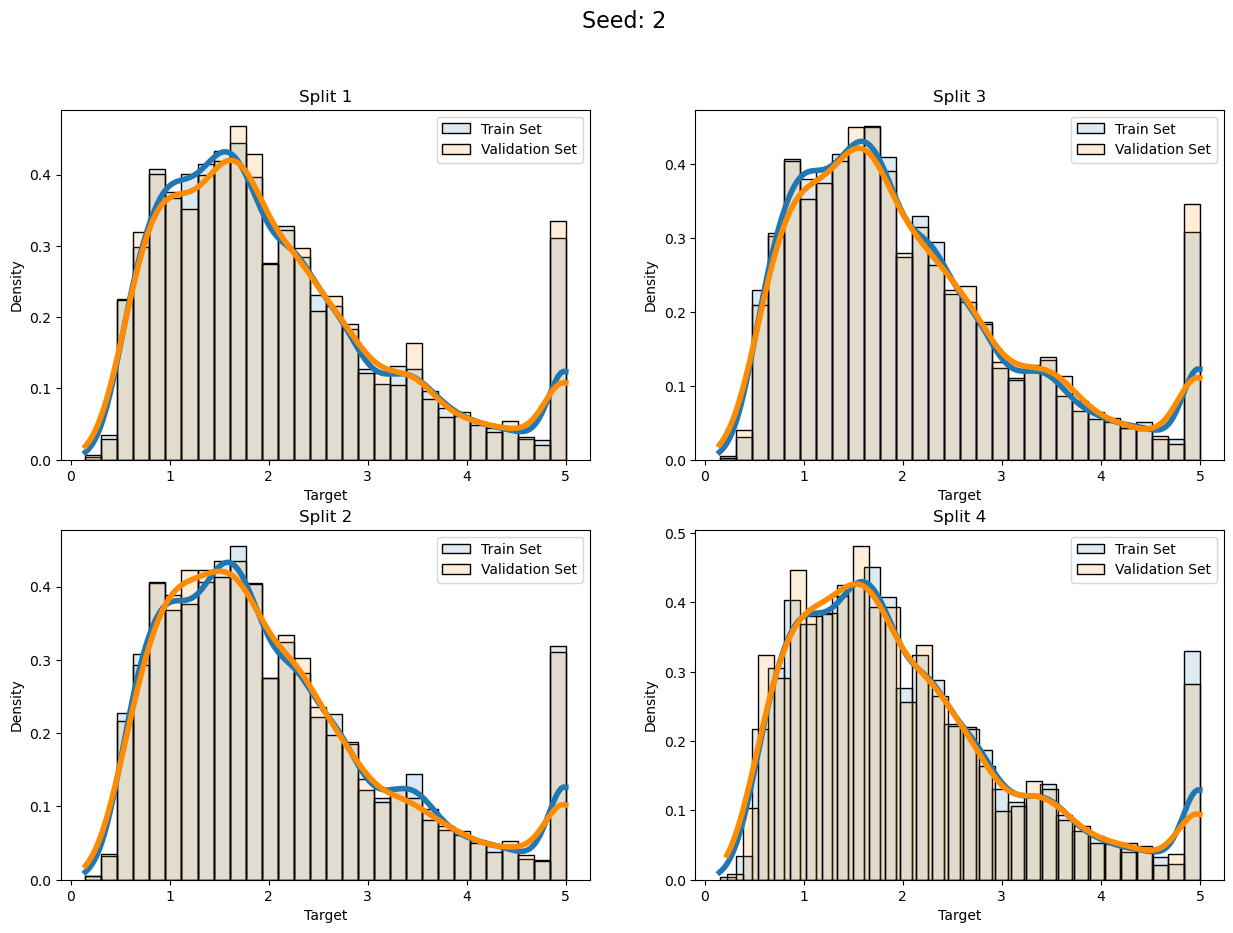

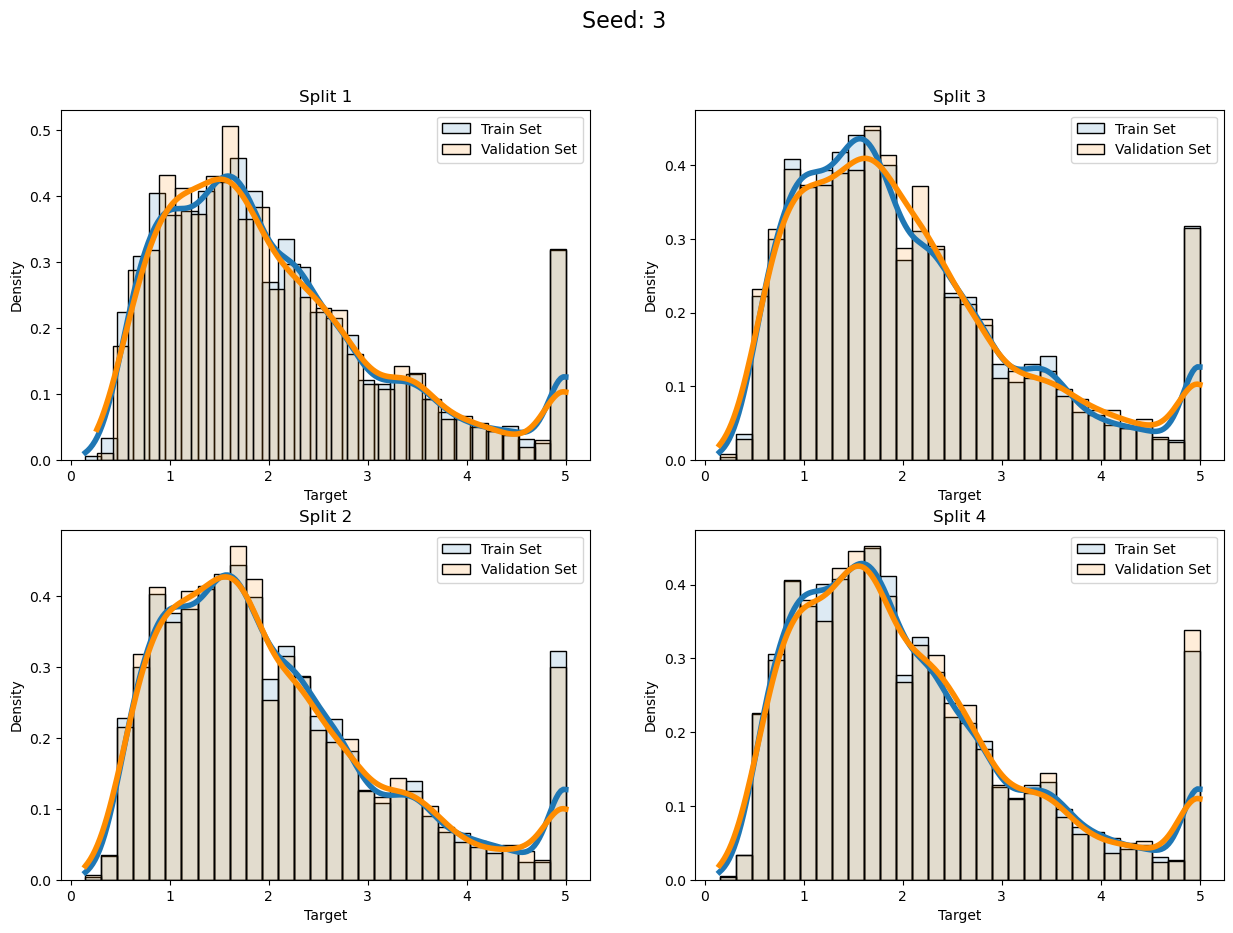

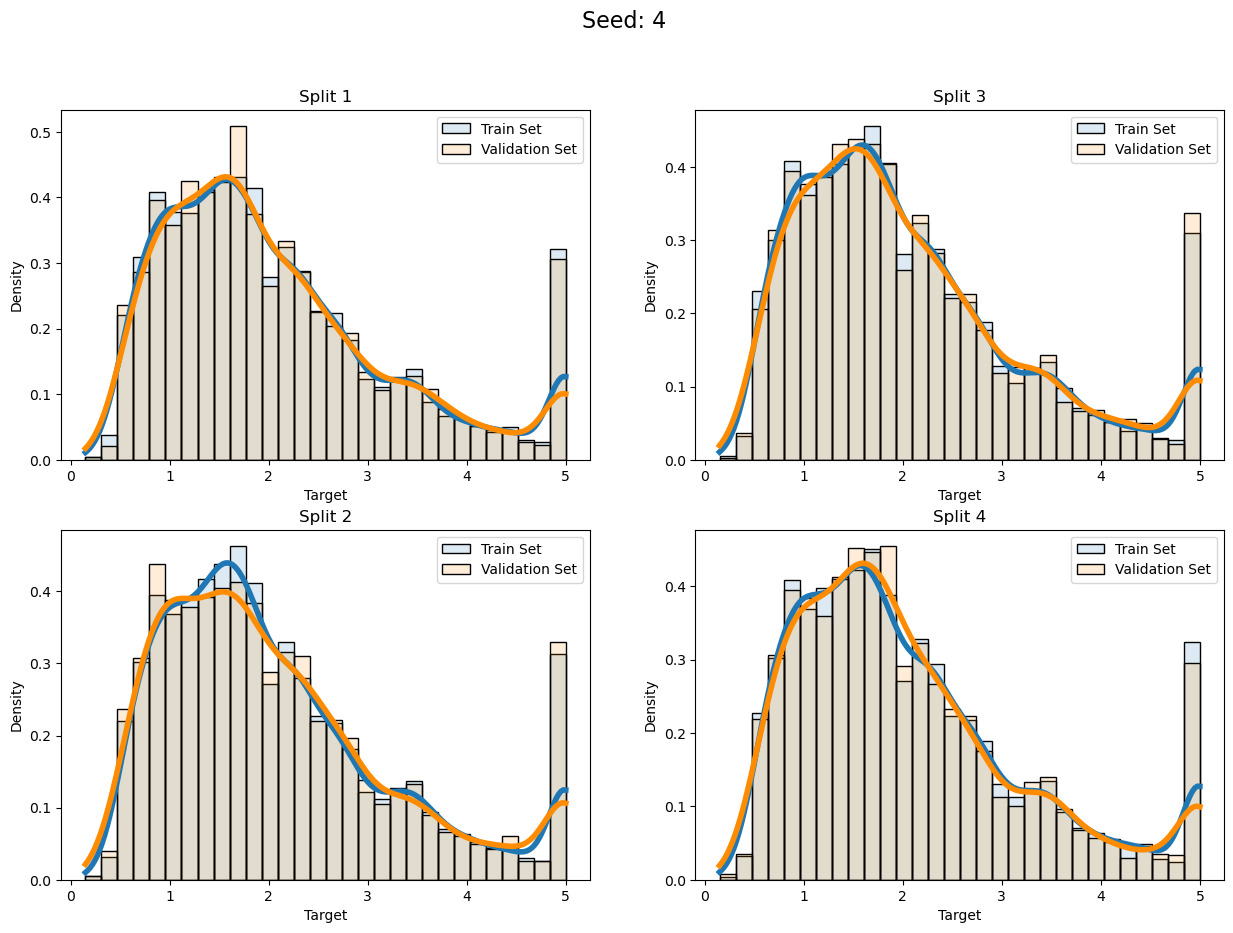

In [9]:
from sklearn.model_selection import KFold
labels = housing["Target"]


for i in range(5):
    baseline_kfold = list(KFold(4,
                                shuffle=True,
                                random_state=i
                               ).split(labels))
    fold_visualizer(data=labels,
                    fold_idxs=baseline_kfold,
                    seed_num=i)

In [10]:
# RandomForestRegressor with baseline_kfold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# evlauating the model with cross validation (doesn't really make sense ???)
cros_val_scores = cross_val_score(tree, housing, labels, cv=baseline_kfold)
print("Cross-validation scores: {}".format(cros_val_scores))
print("Average cross-validation score: {:.2f}".format(cros_val_scores.mean()))


Cross-validation scores: [0.99998143 0.99998232 0.99998254 0.99998327]
Average cross-validation score: 1.00


## With stratification

In [12]:
def create_cont_folds(df, n_s=8, n_grp=10, seed=1):
    # StratifiedKFold for classification
    skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=seed)
    # q/n_grp = Number of quantiles
    grp = pd.qcut(x = df, q = n_grp, labels=False)
    target = grp
    
    fold_nums = np.zeros(len(df))
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        fold_nums[v] = fold_no
    
    cv_splits = []

    for i in range(num_of_folds):
        test_indices = np.argwhere(fold_nums==i).flatten()
        train_indices = list(set(range(len(labels))) - set(test_indices))
        cv_splits.append((train_indices, test_indices))
        
    return cv_splits

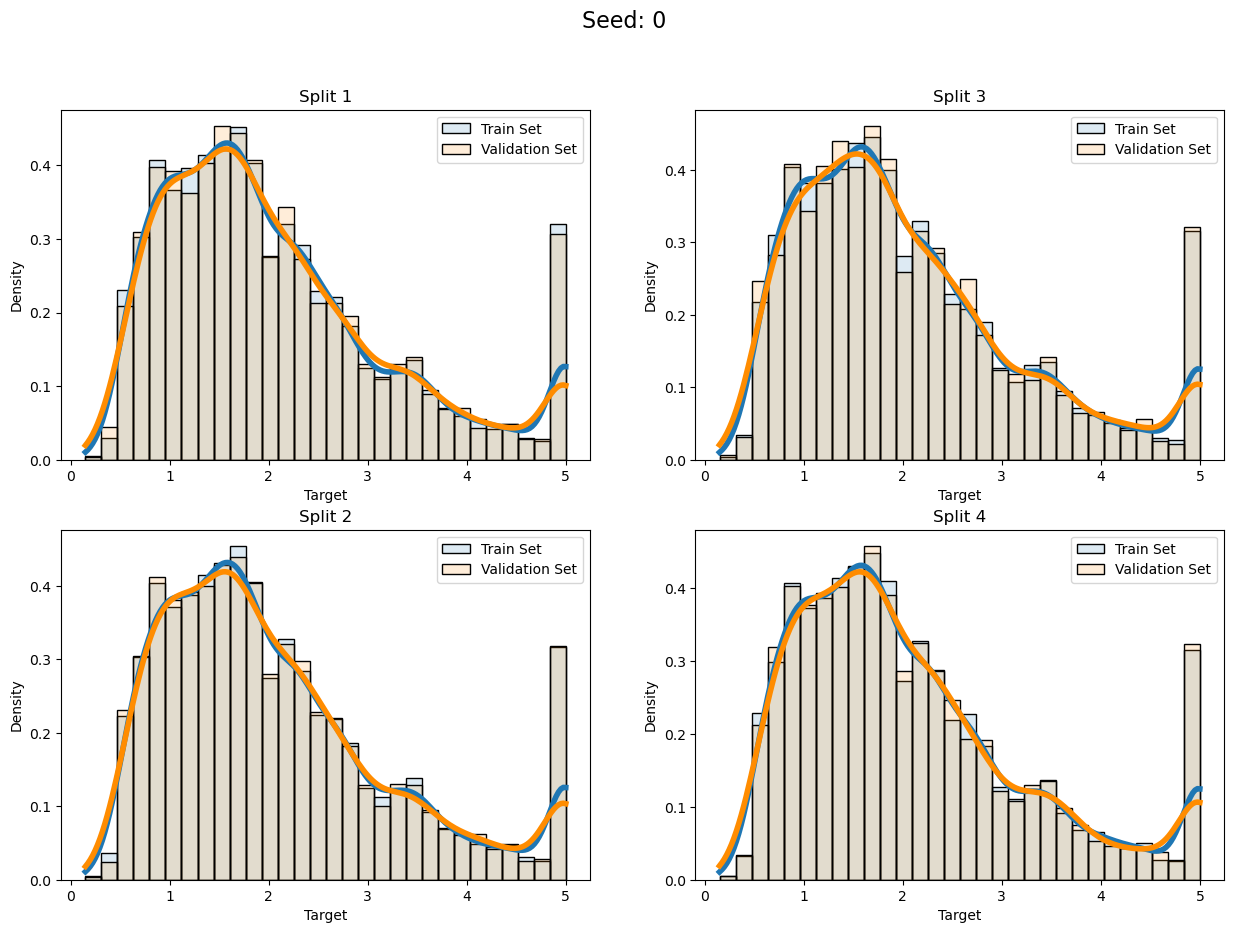

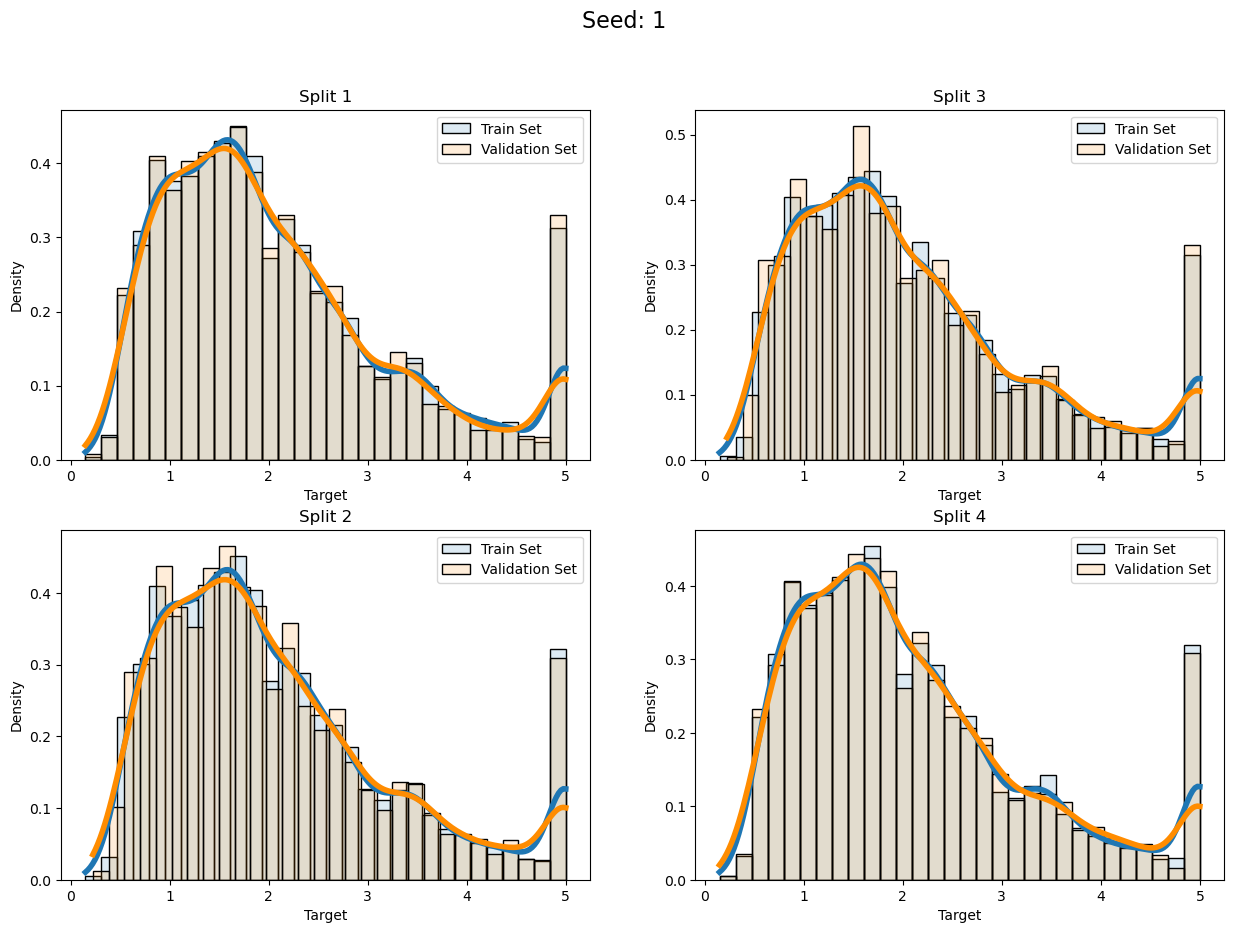

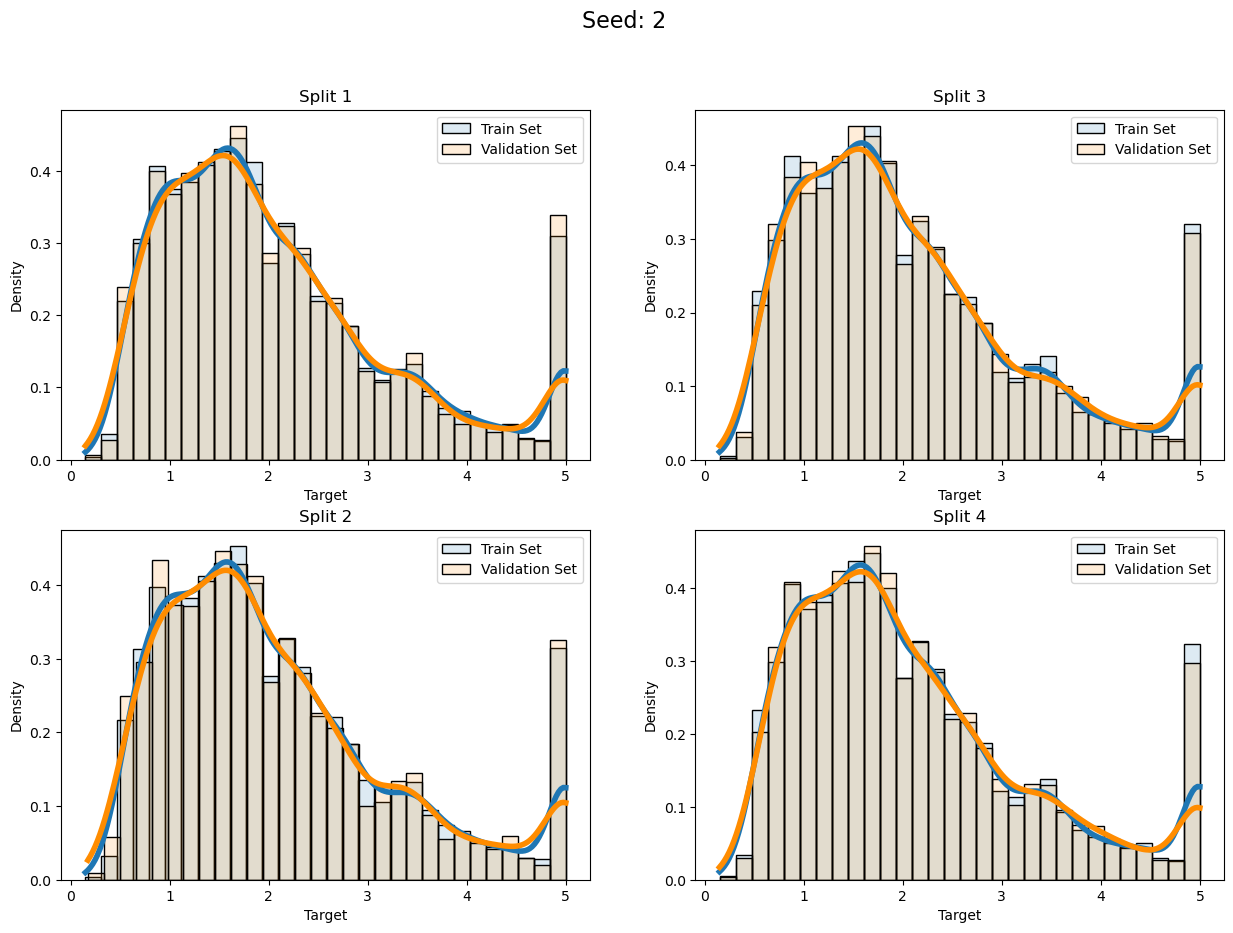

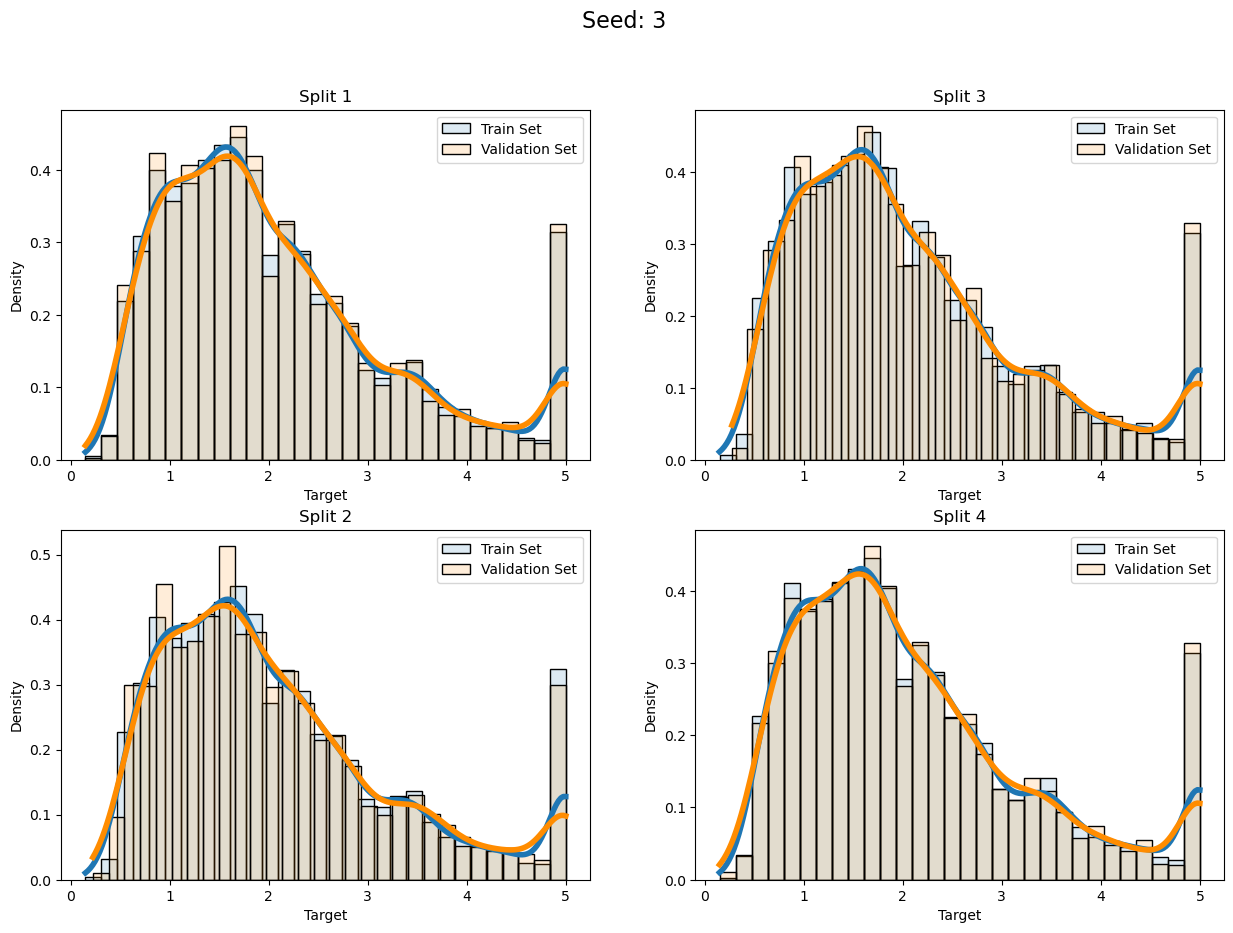

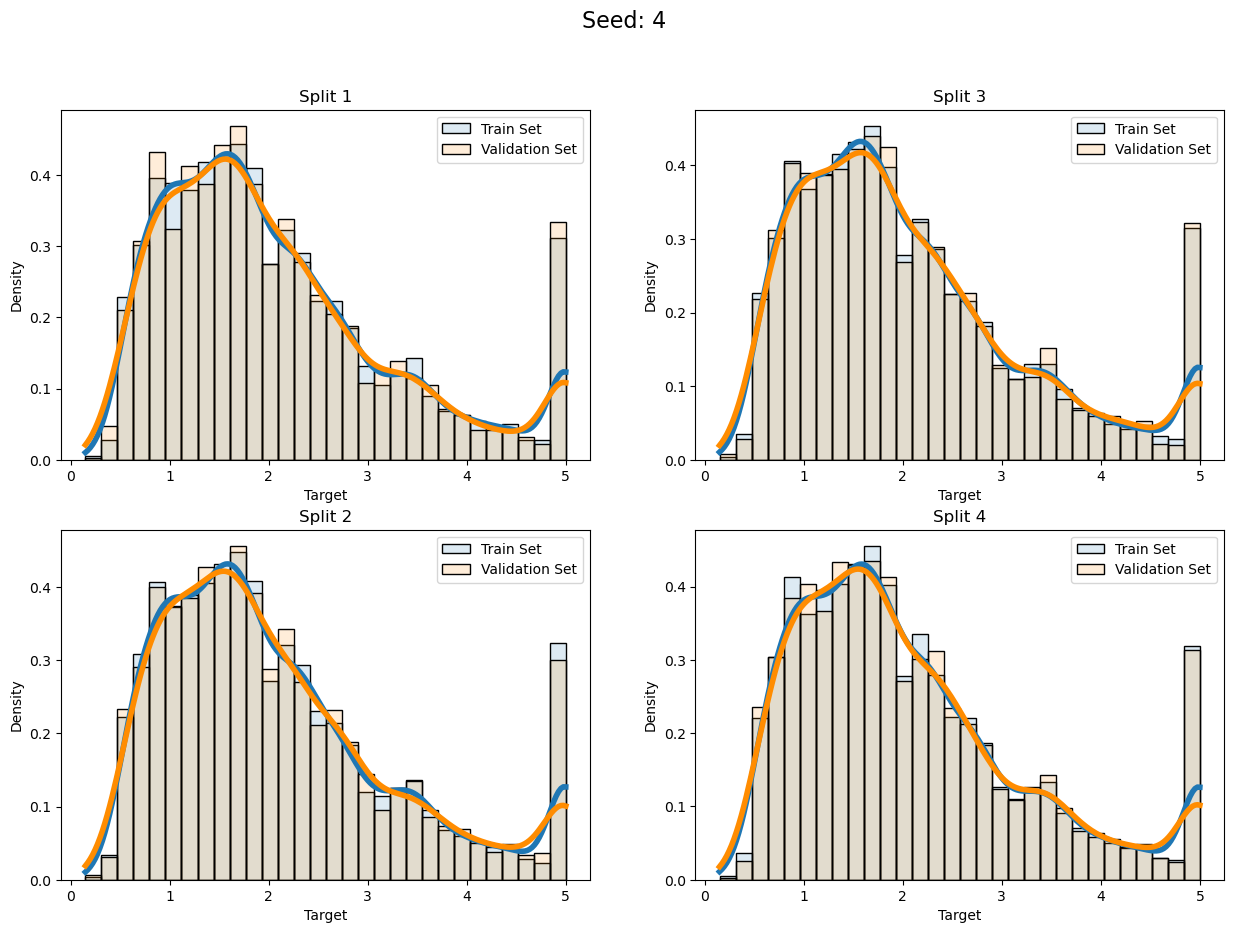

In [13]:
num_of_folds = 4
num_of_groups = 10

for i in range(5):
    cv_splits = create_cont_folds(labels, n_s=num_of_folds, n_grp=num_of_groups, seed=i)
    fold_visualizer(data=labels,
                    fold_idxs=cv_splits,
                    seed_num=i)

In [14]:
X_train_stratified = housing.loc[cv_splits[0][0], housing.columns != 'Target']
y_train_stratified = housing.loc[cv_splits[0][0], 'Target']

X_test_stratified = housing.loc[cv_splits[0][1], housing.columns != 'Target']
y_test_stratified = housing.loc[cv_splits[0][1], 'Target']

In [20]:
tree_stratified =  RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42)
tree_stratified.fit(X_train_stratified, y_train_stratified)
t1_stratified = tree_stratified.score(X_train_stratified, y_train_stratified)
t2_stratified = tree_stratified.score(X_test_stratified, y_test_stratified)

print('R² of stratified RandomForestRegressor on training set: {:.3f}'.format(t1))
print('R² of stratified RandomForestRegressor on test set: {:.3f}'.format(t2))

R² of stratified RandomForestRegressor on training set: 0.762
R² of stratified RandomForestRegressor on test set: 0.733


In [21]:
print('R² of RandomForestRegressor on training set (random samploing): {:.3f}'.format(t1))
print('R² of RandomForestRegressoron test set (random samploing): {:.3f}'.format(t2))

R² of RandomForestRegressor on training set (random samploing): 0.762
R² of RandomForestRegressoron test set (random samploing): 0.733
